## Attention Mechanisms

In this exercise we will write a attention mechanism to solve the following problem

"Given a length 10 sequence of integers, are there more '2s' than '4s' ?"

This could of course be easily handled by a fully connected network, but we'll force the network
to learn this by learning to place attention on the right values. I.e. the strategy is

* embed the individual integer into a high-dimensional vector (using torch.nn.Embedding)
* once we have those embeddings compute how much attention to place on each vector by comparing "key" values computed from the embedded values 
* compute "answer" values to our query by weighting the individual responsed by their attention value


$$
v_{ik} = \mathrm{softmax}_\mathrm{keys}(\frac{q_{i}\cdot k_{j}}{\sqrt{d}}) v_{jk}
$$


## Step 1 - Generating Data

Write a data-generating function that produces a batch of N examples or length-10 sequences of random integers between 0 and 9 as well as a binary label indicating whether the sequence has more 2s than 4s. The output should return (X,y), where X has shape `(N,10)` and y has shape `(N,1)`


## Step 2 - Embedding the Integers

Deep Learning works well in higher dimensions. So we'll embed the 10 possible integers into a vector space using `torch.nn.Embedding`


* Verify that using e.g. a module like `torch.nn.Embedding(10,embed_dim)` achieves this
* Take a random vector of integers of shape (N,M) and evaluate them through an embedding module
* Does the output dimension make sense?

## Step 3 - Extracting Keys and Values 

Once data is embedded we can extract keys and values by a linear projection

* For 2 linear layers `torch.nn.Linear(embed_dim,att_dim)` we can extract keys and values for the output of the previous step
* verify that this works from a shape perspective


## Step 4 - Computing Attention

Implement the Attention-formula from above in a batched manner, such that for a input set of sequences `(N,10)`
you get an output set of attention-weighted values `(N,1)`

* It's easiest when using the function `torch.einsum` which uses the Einstein summation you may be familiar with from special relativity
* e.g. a "batched" dot product is performed using `einsum('bik,bjk->bij')` where `b` indicates the batch index, `i` and `j` are position indices and `k` are the coordinates of the vectors


## Step 5 - Integrate into a Module

Complete the following torch Module:

```python
class AttentionModel(torch.nn.Module):
    def __init__(self):
        super(AttentionModel,self).__init__()
        self.embed_dim = 5
        self.att_dim = 5
        self.embed = torch.nn.Embedding(10,self.embed_dim)
        
        #one query
        self.query  = torch.nn.Parameter(torch.randn(1,self.att_dim))
        
        #used to compute keys
        self.WK = torch.nn.Linear(self.embed_dim,self.att_dim)
        
        #used to compute values
        self.WV = torch.nn.Linear(self.embed_dim,1)
        
        #final decision based on attention-weighted value
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(1,200),
            torch.nn.ReLU(),
            torch.nn.Linear(200,1),
            torch.nn.Sigmoid(),
        )

    def attention(self,x):
        # compute attention
        ...
    
    def values(self,x):
        # compute values
        ...
                
    def forward(self,x):
        # compute final classification using attention, values and final NN
      
```
  
## Step 6 - Train and Plot the Model

Once you have the model completed, train the model. My suggestion is to use a batch size of 500 and a learning rate of 5e-5.

* Write a training loop that trains on binary cross entropy.

You can visualize the output e.g. using this plotting function, that receives the model, a batch size as well as a loss trajectory. If everything is working right we should be seeing that the model is paying attention mostly on the 2s and 4s as we would expect

```python
def plot(model,N,traj):
    x,y = make_batch(N)
    f,axarr = plt.subplots(1,3)
    f.set_size_inches(13,2)
    ax = axarr[0]
    at = model.attention(model.embed(x))[:,0,:].detach().numpy()
    ax.imshow(at)
    ax = axarr[1]
    
    
    vals = model.values(model.embed(x))[:,:,0].detach().numpy()
    nan = np.ones_like(vals)*np.nan
    nan = np.where(at > 0.1, vals, nan)
    ax.imshow(nan,vmin = -1, vmax = 1)
    for i,xx in enumerate(x):
        for j,xxx in enumerate(xx):
            ax = axarr[0]
            ax.text(j,i,xxx.numpy(), c = 'r' if (xxx in [2,4]) else 'w')    
            ax = axarr[1]
            ax.text(j,i,xxx.numpy(), c = 'r' if (xxx in [2,4]) else 'w')    
    ax = axarr[2]
    ax.plot(traj)
```



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def make_batch(N):
    x = torch.randint(0,9,size = (N,10))
    more_twos_than_fours = torch.FloatTensor([len(xx[xx==2]) > len(xx[xx==4]) for xx in x])
    return x,more_twos_than_fours.reshape(-1,1)

x,y = make_batch(100)
x.shape,y.shape

(torch.Size([100, 10]), torch.Size([100, 1]))

In [2]:
numbers = torch.randint(0,9,size = (12,10))
embed = torch.nn.Embedding(10,5)
embedded = embed(numbers)
embedded.shape

torch.Size([12, 10, 5])

In [3]:
key_proj = torch.nn.Linear(5,32)
val_proj = torch.nn.Linear(5,32)
key_proj(embedded).shape, val_proj(embedded).shape

(torch.Size([12, 10, 32]), torch.Size([12, 10, 32]))

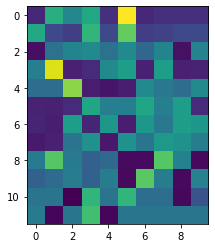

In [4]:
query = torch.randn(1,32)
keys = key_proj(embedded)
values = key_proj(embedded)
qk = torch.einsum('ik,bjk->bij',query,keys)
att = torch.softmax(qk/(32**0.5),dim=-1)
plt.imshow(att[:,0,:].detach())

In [11]:
class AttentionModel(torch.nn.Module):
    def __init__(self):
        super(AttentionModel,self).__init__()
        self.embed_dim = 5
        self.att_dim = 5
        self.embed = torch.nn.Embedding(10,self.embed_dim)
        
        #one query
        self.query  = torch.nn.Parameter(torch.randn(1,self.att_dim))
        
        #used to compute keys
        self.WK = torch.nn.Linear(self.embed_dim,self.att_dim)
        
        #used to compute values
        self.WV = torch.nn.Linear(self.embed_dim,1)
        
        #final decision based on attention-weighted value
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(1,200),
            torch.nn.ReLU(),
            torch.nn.Linear(200,1),
            torch.nn.Sigmoid(),
        )

    def attention(self,x):
        queries = self.query
        keys = self.WK(x)
        qk = torch.einsum('ik,bjk->bij',queries,keys)
        att = torch.softmax(qk/(self.att_dim**0.5),dim=-1)
        return att
    
    def values(self,x):
        return self.WV(x)
                
    def forward(self,x):
        x = self.embed(x)
        att = self.attention(x)
        values = self.values(x)
        aggreg = torch.einsum('bij,bjk->bik',att,values)
        return self.nn(aggreg[:,0,:])      

In [18]:
def plot(model,N,traj):
    x,y = make_batch(N)
    f,axarr = plt.subplots(1,3)
    f.set_size_inches(10,2)
    ax = axarr[0]
    at = model.attention(model.embed(x))[:,0,:].detach().numpy()
    ax.imshow(at)
    ax = axarr[1]
    
    
    vals = model.values(model.embed(x))[:,:,0].detach().numpy()
    nan = np.ones_like(vals)*np.nan
    nan = np.where(at > 0.1, vals, nan)
    ax.imshow(nan,vmin = -1, vmax = 1)
    for i,xx in enumerate(x):
        for j,xxx in enumerate(xx):
            ax = axarr[0]
            ax.text(j,i,xxx.numpy(), c = 'r' if (xxx in [2,4]) else 'w')    
            ax = axarr[1]
            ax.text(j,i,xxx.numpy(), c = 'r' if (xxx in [2,4]) else 'w')    
    ax = axarr[2]
    ax.plot(traj)
    f.set_tight_layout(True)

x,y = make_batch(3)
AttentionModel().forward(x).shape,x.shape,y.shape

(torch.Size([3, 1]), torch.Size([3, 10]), torch.Size([3, 1]))

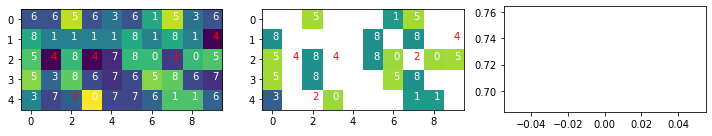

0 tensor(0.7242, grad_fn=<BinaryCrossEntropyBackward0>)


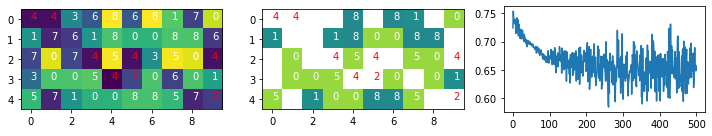

500 tensor(0.6564, grad_fn=<BinaryCrossEntropyBackward0>)


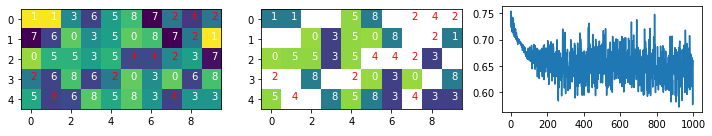

1000 tensor(0.6597, grad_fn=<BinaryCrossEntropyBackward0>)


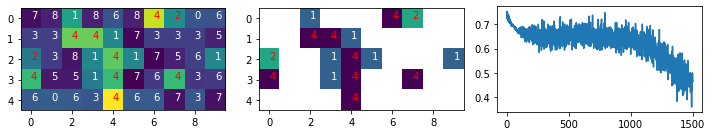

1500 tensor(0.4649, grad_fn=<BinaryCrossEntropyBackward0>)


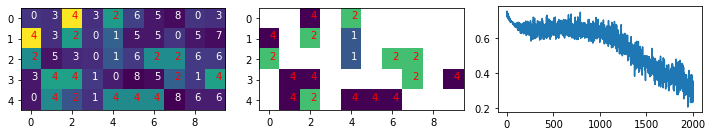

2000 tensor(0.3043, grad_fn=<BinaryCrossEntropyBackward0>)


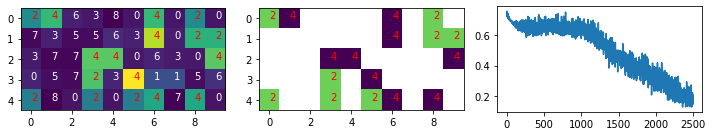

2500 tensor(0.2056, grad_fn=<BinaryCrossEntropyBackward0>)


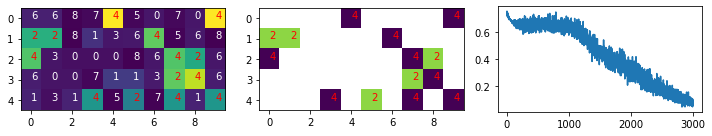

3000 tensor(0.0776, grad_fn=<BinaryCrossEntropyBackward0>)


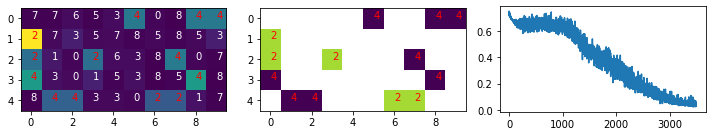

3500 tensor(0.0396, grad_fn=<BinaryCrossEntropyBackward0>)


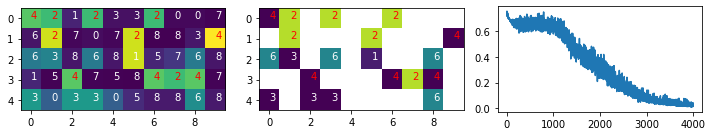

4000 tensor(0.0160, grad_fn=<BinaryCrossEntropyBackward0>)


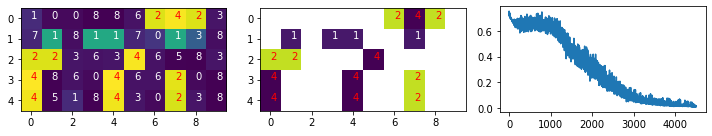

4500 tensor(0.0108, grad_fn=<BinaryCrossEntropyBackward0>)


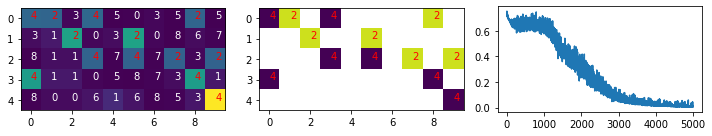

5000 tensor(0.0103, grad_fn=<BinaryCrossEntropyBackward0>)


In [40]:
def train():
    model = AttentionModel()
    opt = torch.optim.Adam(model.parameters(),lr = 1e-4)
    s = 2
    traj = []
    for i in range(5001):
        x,y = make_batch(100)
        p = model.forward(x)
        loss = torch.nn.functional.binary_cross_entropy(p,y)
        loss.backward()
        traj.append(float(loss))
        if i % 500 == 0:
            plot(model,5,traj)
            plt.savefig('attention_{}.png'.format(str(i).zfill(6)))
            plt.show()
            print(i,loss)
        opt.step()
        opt.zero_grad()
    return traj

training = train()